# Анализ выживаемости

In [ ]:
# !pip install lifelines
import lifelines
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Прогностические модели

Что такое прогноз? Предсказание риска наступления какого-либо события. Событием может быть смерть, приобретение какого-либо заболевания (инфаркт, инсульт) и тд. Построение прогнозов важно для своевременного медицинского обслуживания пациентов. Прогностические модели принимают на вход некоторые данные о пациентах (это могут быть результаты анализов, физические характеристики: рост, вес и тд) и на выход выдает некоторое значение, отображающее уровень риска. Можно привести пример нескольких таких прогностических моделей:

<img src="https://www.researchgate.net/publication/233902202/figure/tbl3/AS:203111017783307@1425436848596/CHADS2-VASC-score-and-annual-stroke-risk.png" width=600 height=400/>

<img src="https://cdn.hepatitisc.uw.edu/doc/91-3/model-end-stage-liver-disease-meld-score-calculator.jpg" width=600 height=400/>

## Оценка прогностических моделей

__C-index__(concordance index) оценивает качество прогностической модели на парах пациентов. __Конкордантными__ парами называются такие пары пациентов, когда пациент, для которого наступило прогнозируемое событие наступило, обладает большим скором прогностической модели, противоположнай случай дает __дискордантную__ пару. Также существуют случаи __ничьей__, при которых пара пациентов с одинаковым скором различается по статусу наступившего прогнозируемого события. При этом ничьей не считаются пары, в которых событие наступило или не наступило у обоих пациентов, с разными скорами, такие пары называются __недопустимыми.

$$C-index = \frac{N_{concordant\, pairs} +0.5\cdot N_{risk\, ties}}{N_{permissible\, pairs}}$$

In [ ]:
from lifelines.utils import concordance_index

names = ['A', 'B', 'C', 'D', 'E']
events = [1, 1, 0, 0, 0]
risks = [0.95, 0.89, 0.33, 0.25, 0.91]

df = pd.DataFrame(data={'Stroke': events, 'Risk score': risks}, index=names)
print(df)
print(f'Concordance index: {concordance_index(events, risks)}')

   Stroke  Risk score
A       1        0.95
B       1        0.89
C       0        0.33
D       0        0.25
E       0        0.91
Concordance index: 0.8333333333333334


#  Что такое анализ выживаемости?

Модели выживаемости являются обобщением прогностических моделей. Если прогностические модели, которые выше мы рассматривали, отвечали на вотпрос: "Какова вероятность наступления события X через год?", то модели выживаемости отвечают на вопрос: "Какова вероятность наступления события Х через вермя t?".

## Survival Function (функция выживания)

__Функция выживания__ &mdash; это функция распределения вероятности $S(t)=P(T>t)$, где T &mdash; время жизни индивида из генеральной совокупности. эта функция определяет вероятность того, что терминальное событие еще не наступило к моменту времени t, что эквивалентно выживанию по истечению времени t.

Есть несколько свойств, которыми обладает функция выживания:

1. $0\leq S(t)\leq 1$
2. $S(t)$ не возрастает

![4 survival functions](https://upload.wikimedia.org/wikipedia/commons/e/e0/Four_survival_functions.svg)

__Анализ выживаемости (survival analysis aka time-to-event analysis)__ изучает влияние различных факторов риска, а также использует их для предсказания __продолжительность времени__ от стартовой точки (условного рождения) до некого терминального события (условной смерти). Изначально, как следует из названия использвоался в медицине для прогнозирования продолджительности жизни пациентов. Однако сейчас помимо медицины у анализа выживаемости есть множество других приложений.

В частности анализ выживаемости может быть использован для прогнозирования оттока клиентов, текучки сотрудников, срока службы изделий и тд.

Пример | Точка старта | Терминальное событие
---|---|---
Отток клиентов | Подписка | Отписка от сервиса
Текучка кадров | Найм сотрудника | Увольнение сотрудника
Срок службы изделий | Начало использования | Порча изделия
Академическая успеваемость | Поступление студента | Выпуск студента
Время ответа на вызов | Время, когда сделан звонок | Прибытие пожарной службы

#### Итак, мы предсказываем длину временного отрезка между стартом и терминальным событием, можем ли мы использовать здель обычную регрессию?
Правильный ответ &mdash; технически можно, но возникнут проблемы с тем, что не со всеми объектами из наблюдаемой выборки произошло терминальное событие. Получаем своего рода проблему пропущенных значений.


## Цензурированные данные

Предположим, что мы пытаемся оценить эффективность лекарства от рака. Мы берем в исследование группу пациентов, даем им лекарство и проводим наблюдение.

Пример | Точка старта | Терминальное событие
---|---|---
Выживаемость пациента | Начало испытания лекарства | Смерть пациента __от рака__

Что может случиться с пациентами во время испытания:
1. Некоторые пациенты могут действительно умереть от рака, что будет считаться терминальным событием
2. Некоторые пациенты могут покинуть исследование раньше срока или же умереть от __не связанных с раком причин__. В таком случае у нас будут данные по пациенту до определенного момента ,но при этом терминальное событие не наступает.
3. Некоторые пациенты могут дожить до конца испытания, в таком случае опять же терминальное событие не наступает.

Таким образом мы знаем интервалы между стартом и терминальным событием для пациентов из 1 категории, для всех остальных ми имеем неполную информацию и знаем только то, что они дожили _до_ определенного момента.

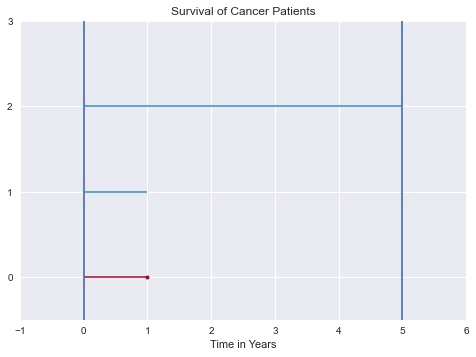

In [ ]:
events = np.array([1, 0, 0])
durations = np.array([1, 5, 1])

ax = lifelines.plotting.plot_lifetimes(durations=durations,
                                       event_observed=events)
ax.set_xlim(-1, 6)

ax.set_xlabel("Time in Years")
ax.set_title("Survival of Cancer Patients")
plt.vlines(5, ymin=-1, ymax=3)
plt.vlines(0, ymin=-1, ymax=3)
plt.plot();


## Что делать с цензурированными данными?

Если бы мы использовали обычную линейную регрессию, мы могли бы поступить следующим образом:

* Могли бы принять допущение, что конечная точка наблюдения всегда является или не является терминальным событием, те. пациент умирает мгновенно или не умирает никогда (плохо)
* Можем считать цензурированные данные пропущенными и не включать их в анализ (тоже плохо)

Но... оба этих способа не дадут нам увидеть адекватную картину происходящего, поскольку мы _знаем_, что с пациентами _не поизошло_ терминальное событие до конкретной временной точки.

В 1980-х стало возможно работать с таким форматом данных

## Оценка Каплана-Мейера

Метод Каплана-Мейера оценивает вероятность выживания исходя из наблюдаемой продолжительности жизни объектов. В результате получается ступенчатая функция изменяющая значения только в тех точках, в которых происходит терминальное событие, для вероятностей выживания также могут быть посчитаны доверительные интервалы.

**KM кривая выживания**, график зависимости вероятности выживания от времени позволяет получить полезную визуализацию данных, также может быть использован для вычисления медианного времени выживаемости.

Оценка Каплана-Мейера не может учитывать факторы риска и не является регрессией.

Это хороший способ визуализировать данные и, например, сравнить эффект нескольких категориальных переменных.


Итак, мы хотим оценить вероятность $S(t)=P(T>t)$. Поскольку время в нашем случае дискретное, вероятность события $T>t$ равна вероятности события $T\geq t+1$. Также мы можем сказать, что событие $T\geq t+1$ наступает тогда же, когда и события $T\geq t$, $T\geq t-1$, ..., $T\geq 0$. Соответственно можем воспользоваться формулой появления зависимых событий: $P(A,B)=P(A|B)\cdot P(B)$:

$$S(t)=P(T>t) = P(T\geq t+1) = P(T\geq t+1,T\geq t, T\geq t-1, ..., T\geq 0) = P(T\geq t+1|T\geq t)\cdot P(T\geq t|T\geq t-1)\cdot...\cdot P(T\geq 1|T\geq 0)P(T\geq 0)$$

Далее рассмотрим вероятность $P(T\geq t+1|T\geq t)$ эта вероятность по сути такая же, что и вероятность $P(T> t|T\geq t)$ в силу нашего дискретного времени. А эту вероятность можно представить следующим образом: $P(T> t|T\geq t) = 1 - P(T=t|T\geq t)$,  соответственно мы можем переписать нашу оценку $S(t)$:

$$S(t) = [1-P(T=t|T\geq t)]\cdot [1-P(T=t-1|T\geq t-1)]\cdot...\cdot [1-P(T=0|T\geq 0)]


Вероятность $P(T=t|T\geq t)$ мы можем оценить непосредственно из наших данных:
$$ P(T=t|T\geq t) = \frac{N_{died \, at \, t}}{N_{survived \, to \, t}} = \frac{d_i}{n_i}$$

Таким образом:

$$S(t) = \prod_{i=0}^t 1-P(T=i|T\geq i) = \prod_{i=0}^t 1-\frac{d_i}{n_i}$$

,Stroke,Durations
A,1,1
B,1,4
C,1,5
D,0,3
E,0,4
F,0,5


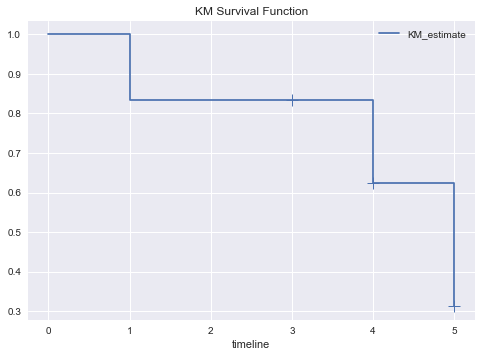

In [ ]:
kmf = lifelines.KaplanMeierFitter()

names = ['A', 'B', 'C', 'D', 'E', 'F']
events = np.array([1, 1, 1, 0, 0, 0])
durations = np.array([1, 4, 5, 3, 4, 5])

df = pd.DataFrame(data={'Stroke': events, 'Durations': durations}, index=names)
display(df)

kmf.fit(durations, events)

kmf.plot_survival_function(show_censors=True, ci_show=False)
plt.title('KM Survival Function');

### Сравнение оценок Каплана-Мейера

Часто оценка Каплана-Мейера используется для сравнения двух выборок, например пациентов подвергнутых и неподвергнутых терапии каким-либо препаратом. Сравнить две оценки можно с помощью __логрангового критерия__. Нулевая гипотеза в таком случае остоит в том, что выживаемость $S_1(t)$ и $S_2(t)$ в группах одинакова и различия случайны. Подробнее можно прочитать [здесь](https://en.wikipedia.org/wiki/Logrank_test).

c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.12 0.04      4.56

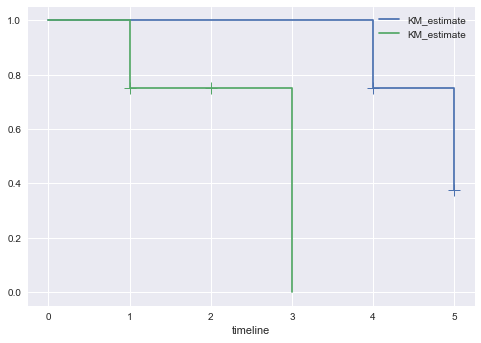

In [ ]:
from lifelines.statistics import logrank_test

names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
events = np.array([1, 1, 1, 1, 0, 0, 0, 0])
durations = np.array([1, 4, 3, 5, 2, 5, 1, 4])
treatment = np.array([0, 1, 0, 1, 0, 1, 0, 1])

df = pd.DataFrame(data={'Stroke': events, 'Durations': durations, 'Treatment': treatment}, index=names)
ix = df['Treatment'] == 1

kmf = lifelines.KaplanMeierFitter()

fig = plt.figure()
fig.subplots_adjust(wspace=0.2)

T_exp, E_exp = df.loc[ix, 'Durations'], df.loc[ix, 'Stroke']

kmf.fit(T_exp, E_exp)

kmf.plot_survival_function(show_censors=True, ci_show=False)

T_con, E_con = df.loc[~ix, 'Durations'], df.loc[~ix, 'Stroke']

kmf.fit(T_con, E_con)

kmf.plot_survival_function(show_censors=True, ci_show=False)

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
results.print_summary()

## Hazard Function

Теперь ответим на вопрос: "Какому риску подвергается пациент, доживший до времени t?". На этот вопрос отвечает параметр __hazard__ или риск. Он обозначается как вероятность:
$$h(t)=P(T=t|T\geq t)$$

Его также можно представить как

$$h(t)=-\frac{S'(t)}{S(t)}$$

В свою очередь, решив дифференциальное уравнение, можем выразить $S(t)$ через $h(t)$

$$s(t)=exp(-\int_0^t h(i)di)$$

__Hazard function__ (функция риска) отражает вероятность наступления терминального события на временном интервале. Обычно она имеет следующий вид:

![Different hazard functions](https://upload.wikimedia.org/wikipedia/commons/2/25/Compsyseng17_04.jpg)

Интеграл $H(t) = \int_0^t h(i)di$ называется куммулятивным риском (cummulative hazard function), и интерпретируется как  суммарный риск, накопленный ко времени t. Можно считать его функцией плотности вероятности $S(t)$.

В дискретном случае $H(t) = \sum_{i=0}^th(i)$


## Инструменты анализа выживаемости
Необходимые данные для проведения анализа выживаемости &mdash; продолжительность наблюдения и цензурирование.

Основные инструменты:
- Kaplan Meier Estimator
- Nelson-Aalen Estimator (в следующем занятии)
- Proportional Hazards (Cox Model)


## `lifelines` library
В 2014 появилась библиотека в Python, которая является надстройкой над pandas, называется `lifelines`.

Также `scikit-learn` выпустил свою библиотеку по анализу выживаемости, которая называется scikit-survival. Её мы также будем использовать на практике.

Давайте посмотрим на примеры данных:

# Лейкимия

`lifelines` содержит несколько встроенных датасетов, один из которых данные по лейкимии

In [ ]:
from lifelines.datasets import load_leukemia

leukemia = load_leukemia()

leukemia.head()

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


In [ ]:
leukemia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       42 non-null     int64  
 1   status  42 non-null     int64  
 2   sex     42 non-null     int64  
 3   logWBC  42 non-null     float64
 4   Rx      42 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 1.8 KB


In [ ]:
leukemia.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\plotting.py:672: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


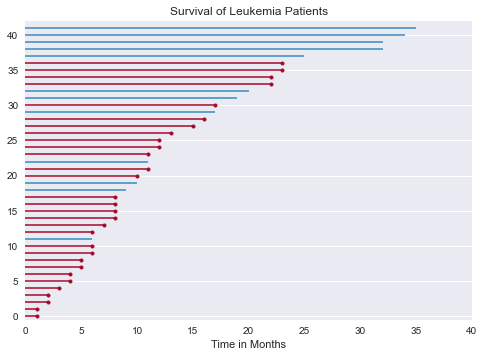

In [ ]:
durations = leukemia.t.values
events = leukemia.status.values

ax = lifelines.plotting.plot_lifetimes(durations=durations,
                                       event_observed=events)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Survival of Leukemia Patients");
plt.plot();

Median Survival: 12.0 months after treatment


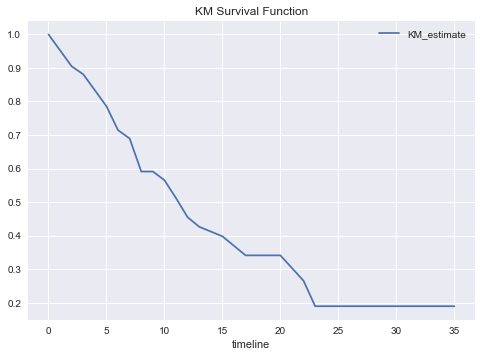

In [ ]:
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations, events)

kmf.survival_function_.plot()
plt.title('KM Survival Function');
print(f'Median Survival: {kmf._median} months after treatment')

Median survival time with Treatment 1: 8.0 months
Median survival time with Treatment 0: 23.0 months


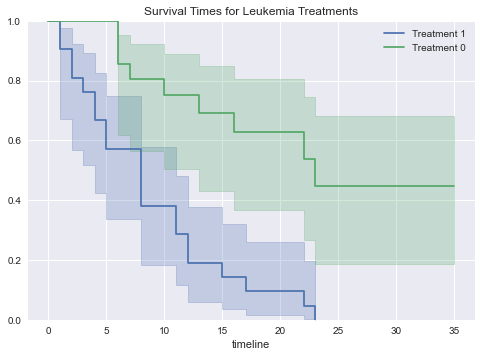

In [ ]:
# compare the effects of a single categorical variable, "Rx"
ax = plt.subplot(111)

treatment = (leukemia["Rx"] == 1)
kmf.fit(durations=durations[treatment],
        event_observed=events[treatment],
        label="Treatment 1")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 1: {kmf._median} months')

kmf.fit(durations=durations[~treatment],
        event_observed=events[~treatment],
        label="Treatment 0")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 0: {kmf._median} months')

plt.ylim(0, 1);
plt.title("Survival Times for Leukemia Treatments");

## Cox Proportional Hazards Model &mdash; регрессия выживаемости

Модель позволяет учесть индивидуальные признаки пациента при оценке рисков наступления терминального события.

$$h(t) = h_0(t)*exp(\sum_{i=0}^n x_i\cdot w_i)


Что такое $h_0(t)$?

In [ ]:
# Using Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(df=leukemia, duration_col='t', event_col='status')
cph.print_summary()

c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
             duration col = 't'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 42
number of events observed = 30
   partial log-likelihood = -69.59
         time fit was run = 2022-12-05 11:03:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.31       1.37       0.45            -0.58             1.21                 0.56                 3.34
logWBC      1.68       5.38       0.34             1.02             2.34                 2.78                10.40
Rx          1.50       4.50       0.46             0.60             2.41                 1.82                11.11

             z      p   -log2(p)
covariate                       
sex       0.69   0.49       1.03
logWBC    5.00 <0.005      20.71
Rx        3.26 <0.005       9.80
---
Concordance = 0.85
Partial AIC = 145.18
log-likelihood ratio test = 47.19 on 3 df
-log2(p) of ll-ratio test = 31.55

### Интерпретация результатов
`coef`: записывается как $b$, коэффициент риска.

`exp(coef)`: $e^{b}$, оценка отношения рисков. Пациент получавший "treatment 1" имел в ~4.5 раза выше риск (смерти) по сравнению с пациентами, получавшими "treatment 2". Аналогично повышенный "logWBC" повышает риск более чем в 5 раз.

`se(coef)`: стандартная ошибка коэффициента $b$ (используется для вычисления z-score и p-value)

`z`: z-score $\frac{b}{se(b)}$

`p`: p-value. рассчитывается через z-score.

`log(p)`: логарифм p-value

`lower/upper 0.95`: доверительные интервалы коэффициента.

#### Concordance (Harrell's c-index)

В данном случае concordance считается иначе, чем мы рассматривали в начале. Здесь речь идет о Harrell's c-index, который может учесть цензурирование данных. Соответственно допустимые пары будут включать только те, где мы можем достоверно сказать, что один пациент прожил дольше другого, например:

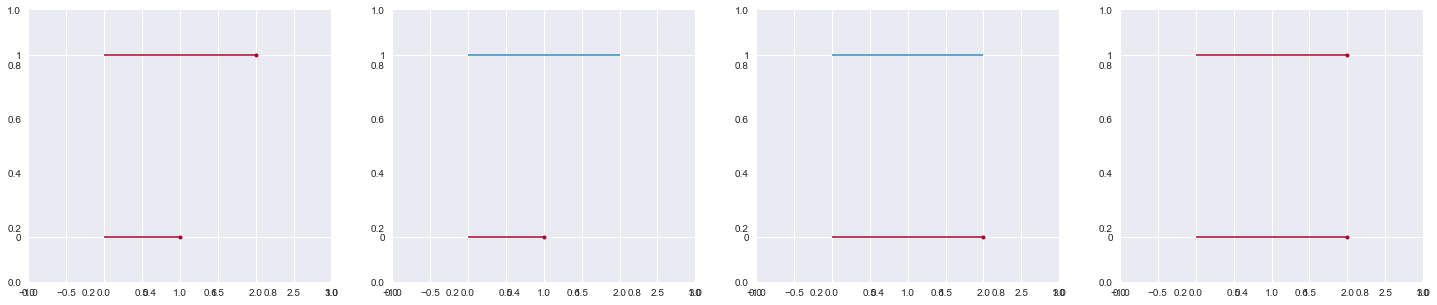

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

for i, j in enumerate([[1, 1, 2, 1], [0, 1, 2, 1], [1, 0, 2, 2], [1, 1, 2, 2]]):
    events = np.array(j[:2])
    durations = np.array(j[2:])

    ax = fig.add_subplot(1,4,i+1)
    lifelines.plotting.plot_lifetimes(durations=durations,
                                      event_observed=events,
                                      ax=ax)
    ax.set_xlim(-1, 3)
    ax.set_ylim(-0.25, 1.25)

plt.plot();

<AxesSubplot:>

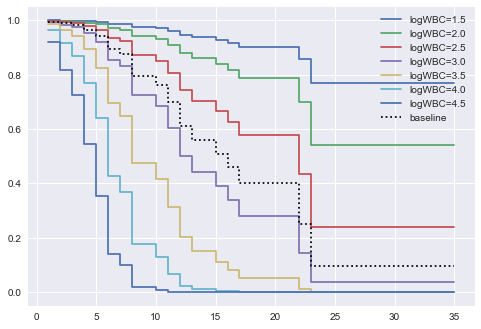

In [ ]:
# investigate continuous feature, must bin with 'values' argument
cph.plot_partial_effects_on_outcome(covariates='logWBC', values=np.arange(1.5,5,.5))

<AxesSubplot:>

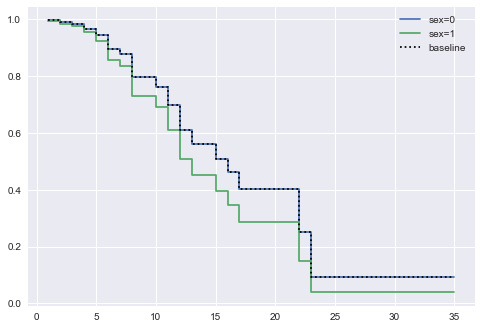

In [ ]:
# categorical feature
cph.plot_partial_effects_on_outcome(covariates='sex', values=[0,1])

Проверка допущения: **модель Кокса использует допущение, что отношение рисков наступления терминального события между группами не изменяется со временем**.

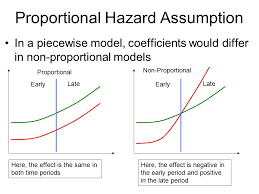

In [ ]:
cph.check_assumptions(leukemia, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
Rx     km              0.23 0.63      0.67
       rank            0.31 0.58      0.79
logWBC km              0.10 0.76      0.40
       rank            0.12 0.73      0.46
sex    km              3.78 0.05      4.27
       rank            4.15 0.04      4.59



1. Variable 'sex' failed the non-proportional test: p-value is 0.0417.

   Advice: with so few unique values (only 2), you can include `strata=['sex', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

Давайте последуем совету функции `check_assumptions`:

>Advice: with so few unique values (only 2), you can try  `strata=['sex']` in the call in `.fit`.

In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(df=leukemia, duration_col='t',
        event_col='status', strata=['sex'])
cph.print_summary()

c:\Users\dyuga\Anaconda3\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
             duration col = 't'
                event col = 'status'
                   strata = ['sex']
      baseline estimation = breslow
   number of observations = 42
number of events observed = 30
   partial log-likelihood = -55.73
         time fit was run = 2022-12-05 10:42:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
logWBC      1.45       4.28       0.34             0.78             2.13                 2.18                 8.40
Rx          1.00       2.71       0.47             0.07             1.93                 1.07                 6.86

             z      p   -log2(p)
covariate                       
logWBC    4.22 <0.005      15.35
Rx        2.11   0.04       4.83
---
Concordance = 0.81
Partial AIC = 115.47
log-likelihood ratio test = 32.06 on 2 df
-log2(p) of ll-ratio test = 23.13

(24, 2)

0    31.141522
1    31.063373
2    26.570820
3    23.308511
4    29.577583
dtype: float64

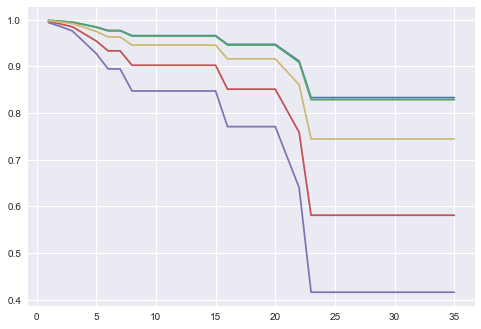

In [ ]:
surv_func = cph.predict_survival_function(leukemia[:5])

exp_lifetime = cph.predict_expectation(leukemia[:5])

plt.plot(surv_func)

exp_lifetime